# Fully-Connected VAE - Final Training

The aim of this notebook is to train the the final chosen arch for the project with the entire 17,500 wildfire sequenced images. We will run a full test of 100 epochs. From the previous experiments, the FNN-VAE doesn't seem to overfit the training data when compared to the validation. That is not too say that we don't overfit the train and val data. Because we are happy with the non-divergent training plots of the FNN-VAEs, we are able to run the 17,500 image train with some confidence.

* naturally, for this task, we are comparing the models by visually inspecting as we no longer have access to unseen test data.

As demonstrated in `FCVAE_gridsearch.ipynb`, we have 2 competing fully-connected VAEs:

  * winner: `[1024 -> 128 -> 16]: lr=0.001: nn.ReLU(): batchsize=32`
  * previous "baseline": `[512 -> 256 -> 128 -> 16]: lr=0.001: nn.ReLU(): batchsize = 32` 

* The final architechtures will be run for the full 17,500 image training and compared.

In [7]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from tqdm import tqdm

from src.generative.utils import (
    get_device,
)

from src.generative.plotting import (
    plot_batch_recon_images,
    generate_images_from_latent_space_vectors,
    plot_generated_images_from_latent_space,
)

from src.generative.model import VAE
from src.generative.training import train_vae

from src.generative.dataset import WildfireImageDataSet

%matplotlib inline
%pylab inline

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [8]:
DEVICE = get_device()

No GPU available! (device = cpu)


In [9]:
# load in the data.
train_data = np.load("data/Ferguson_fire_train.npy")
test_data = np.load(f"data/Ferguson_fire_test.npy")

print("** (raw) DATA INFO **")
print(f"train: type={type(train_data)}, dims={train_data.shape}")
print(f"test: type={type(test_data)}, dims={test_data.shape}")

** (raw) DATA INFO **
train: type=<class 'numpy.ndarray'>, dims=(12500, 256, 256)
test: type=<class 'numpy.ndarray'>, dims=(5000, 256, 256)


* joining the train and test data so that we can train on all 17500 images before generation:

In [10]:
X_train = np.concatenate([train_data, test_data])
X_train.shape

(17500, 256, 256)

In [11]:
transform = transforms.Compose(
    transforms=[
        transforms.ToTensor(),
    ]
)

train_dataset = WildfireImageDataSet(data=X_train, transform=transform)

In [12]:
# KEY PARAMETERS for DATA
batch_size = 32
num_workers = 0

train_loader = torch.utils.data.DataLoader(
    dataset=train_dataset, batch_size=batch_size, num_workers=num_workers, shuffle=True
)

* we will train the models for 100 epochs. They will have the `lr_scheduler` from the `FCVAE_gridsearch.ipynb`.

[1]: `[1024 -> 128 -> 16]: lr=0.001: nn.ReLU(): batchsize=32`

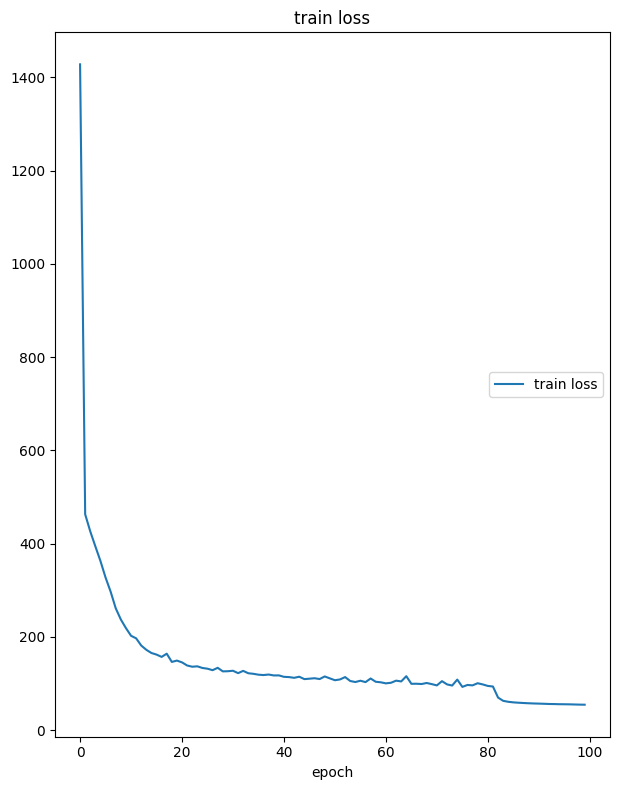

Epoch: 99/100 | Batch: 547/547: 100%|██████████| 54700/54700 [48:50<00:00, 18.67batch/s, loss=55.8]

train loss
	train loss       	 (min:   54.649, max: 1427.878, cur:   54.649)


In [56]:
model = VAE(
    input_image_dims=(1, 256, 256),
    hidden_layers=[1024, 128],
    latent_dims=16,
    activation=nn.ReLU,  # starting w/ RELU
    device=DEVICE,
).to(DEVICE)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, amsgrad=False)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode="min", factor=0.1, patience=5
)

model, train_losses, val_losses = train_vae(
    n_epochs=100,
    model=model,
    optimizer=optimizer,
    scheduler=scheduler,
    train_loader=train_loader,
    val_loader=None,
    model_save_path="vae_relu_1024_128_ld16_bs16_001_all_data_100epochs.pt",
    use_liveloss=True,
    device=DEVICE,
)

random idxs = tensor([20,  2, 24,  3, 20,  8,  4, 20])


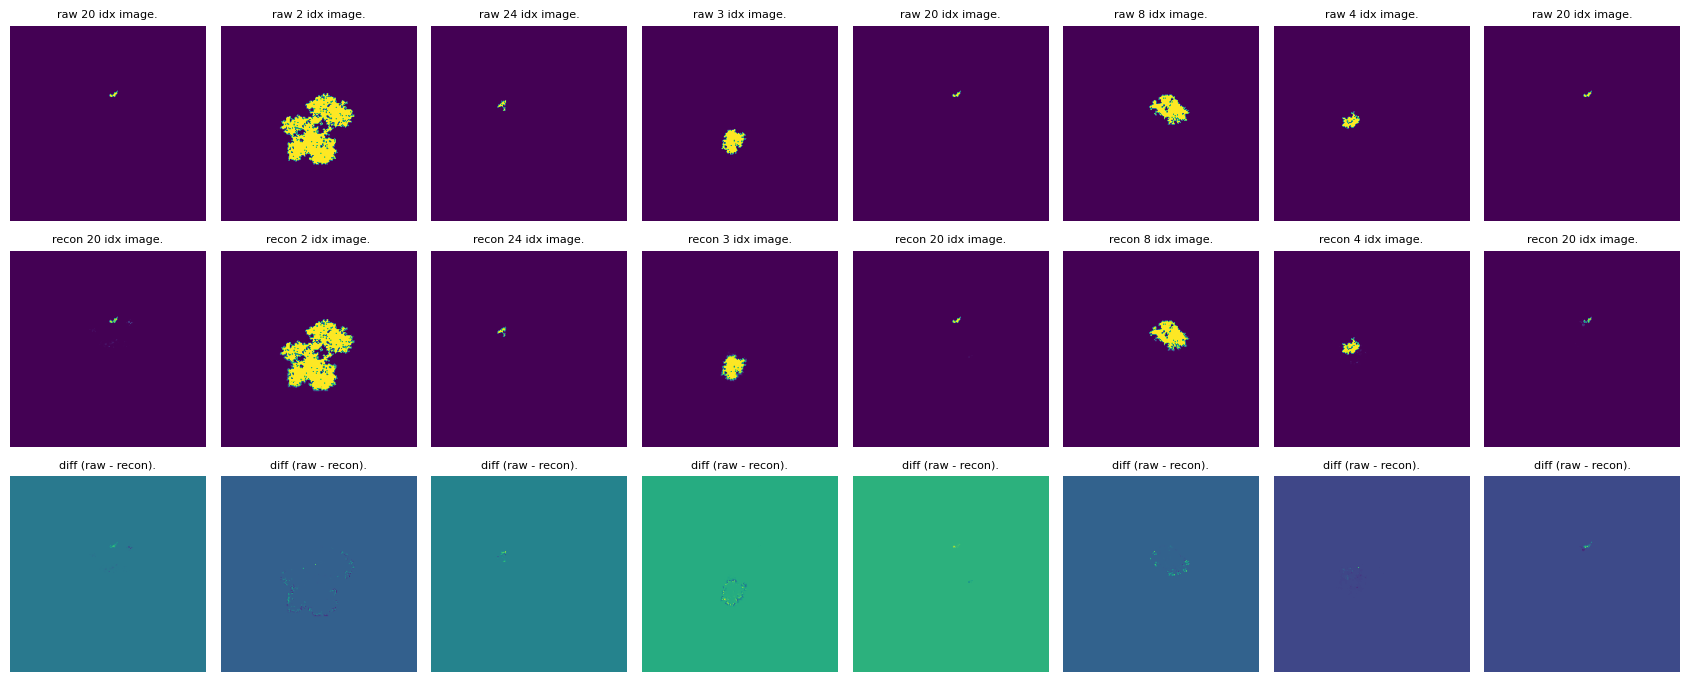

In [58]:
plot_batch_recon_images(
    model=model,
    data_loader=train_loader,
    num_images=8,
    device=DEVICE,
)

* The model used is the "winner" w/ `ReLU`
* stable training with a good drop in the `MSE()` from the scheduler. 
* MSE = **54.649** (on training)

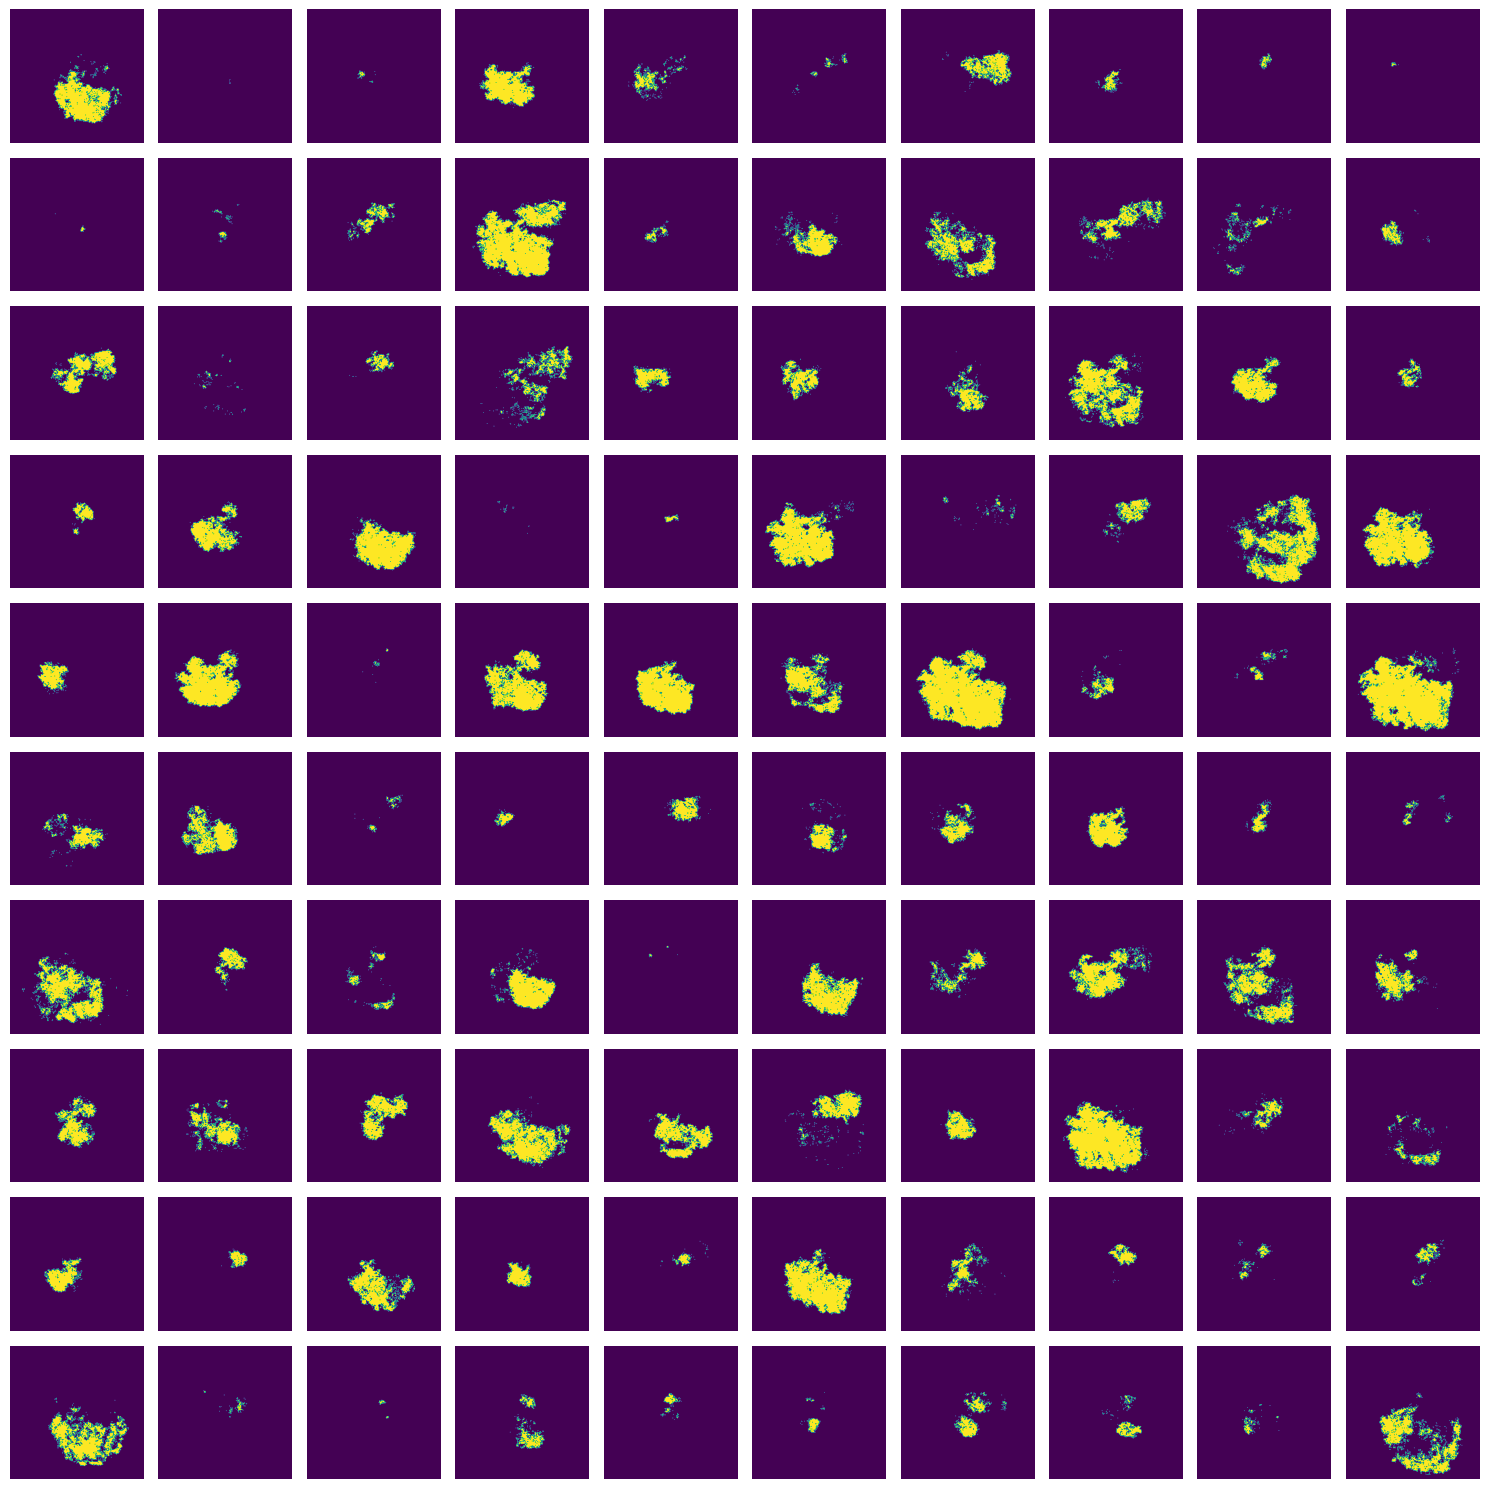

In [68]:
plot_generated_images_from_latent_space(
    model=model,
    num_samples=100,
    latent_dim=16,
    img_dims=(256, 256),
    pixel_threshold=None,
)

#### [training squeeze]: dropping the learning rate by factor of 10 and running it for 30 more epochs using 0.0001 (1e-4)

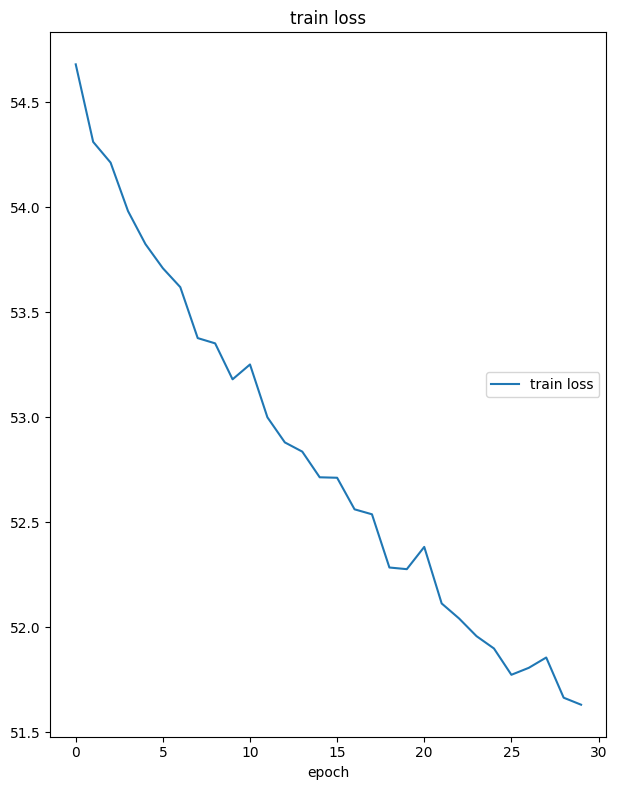

Epoch: 29/30 | Batch: 547/547: 100%|██████████| 16410/16410 [17:11<00:00, 15.92batch/s, loss=40.5]

train loss
	train loss       	 (min:   51.631, max:   54.679, cur:   51.631)


In [70]:
# load in the best model:
path = "vae_relu_1024_128_ld16_bs16_001_all_data_100epochs.pt"
model.load_state_dict(
    torch.load(path, map_location=torch.device(DEVICE))["model_state_dict"]
)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, amsgrad=True)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode="min", factor=0.1, patience=5
)

model, train_losses, val_losses = train_vae(
    n_epochs=30,
    model=model,
    optimizer=optimizer,
    scheduler=scheduler,
    train_loader=train_loader,
    val_loader=None,
    model_save_path="vae_relu_1024_128_ld16_bs16_001_all_data_100epochs_plus30.pt",
    use_liveloss=True,
    device=DEVICE,
)

random idxs = tensor([23, 30, 13, 24, 26, 30, 22, 27])


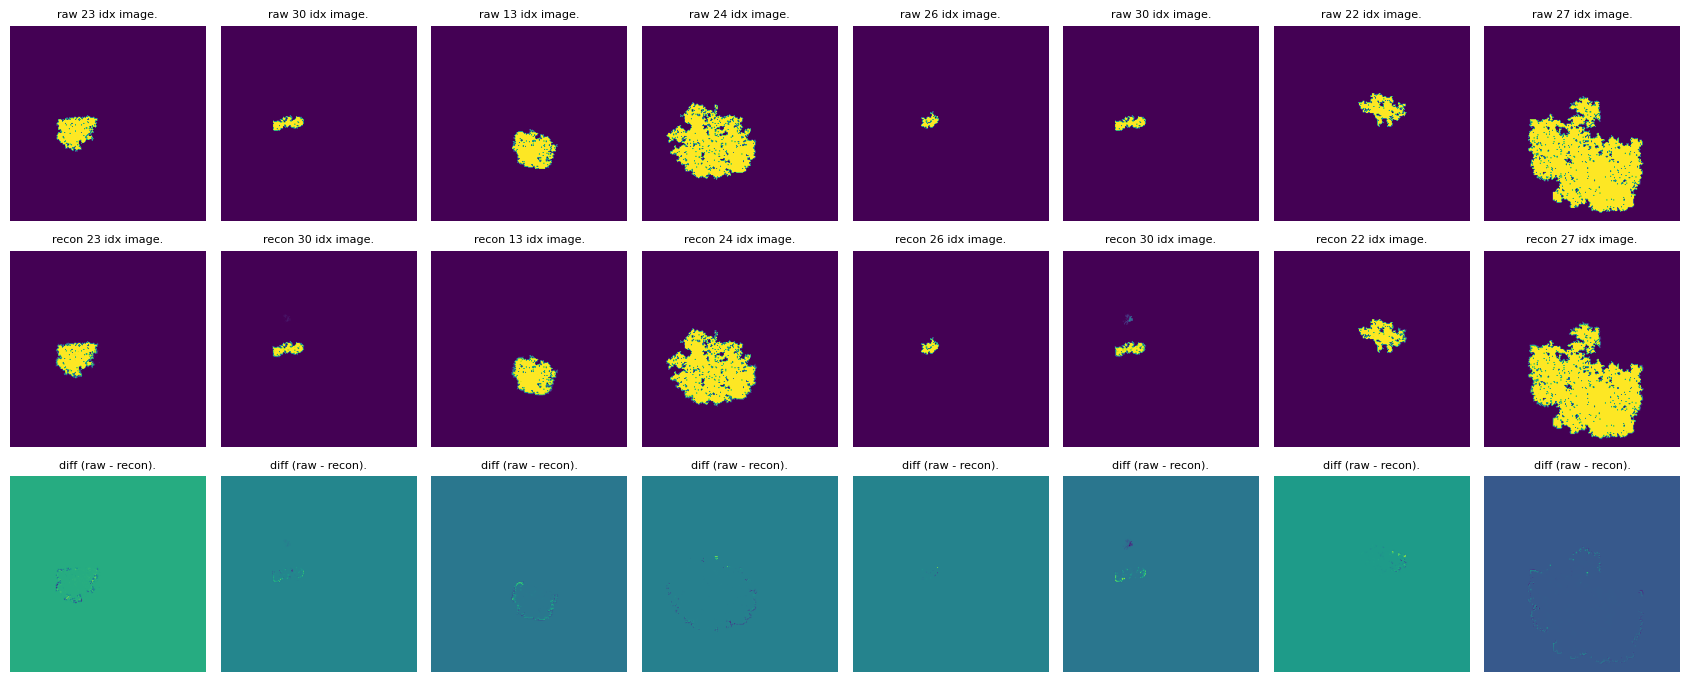

In [73]:
plot_batch_recon_images(
    model=model,
    data_loader=train_loader,
    num_images=8,
    device=DEVICE,
)

* train recons are very good.

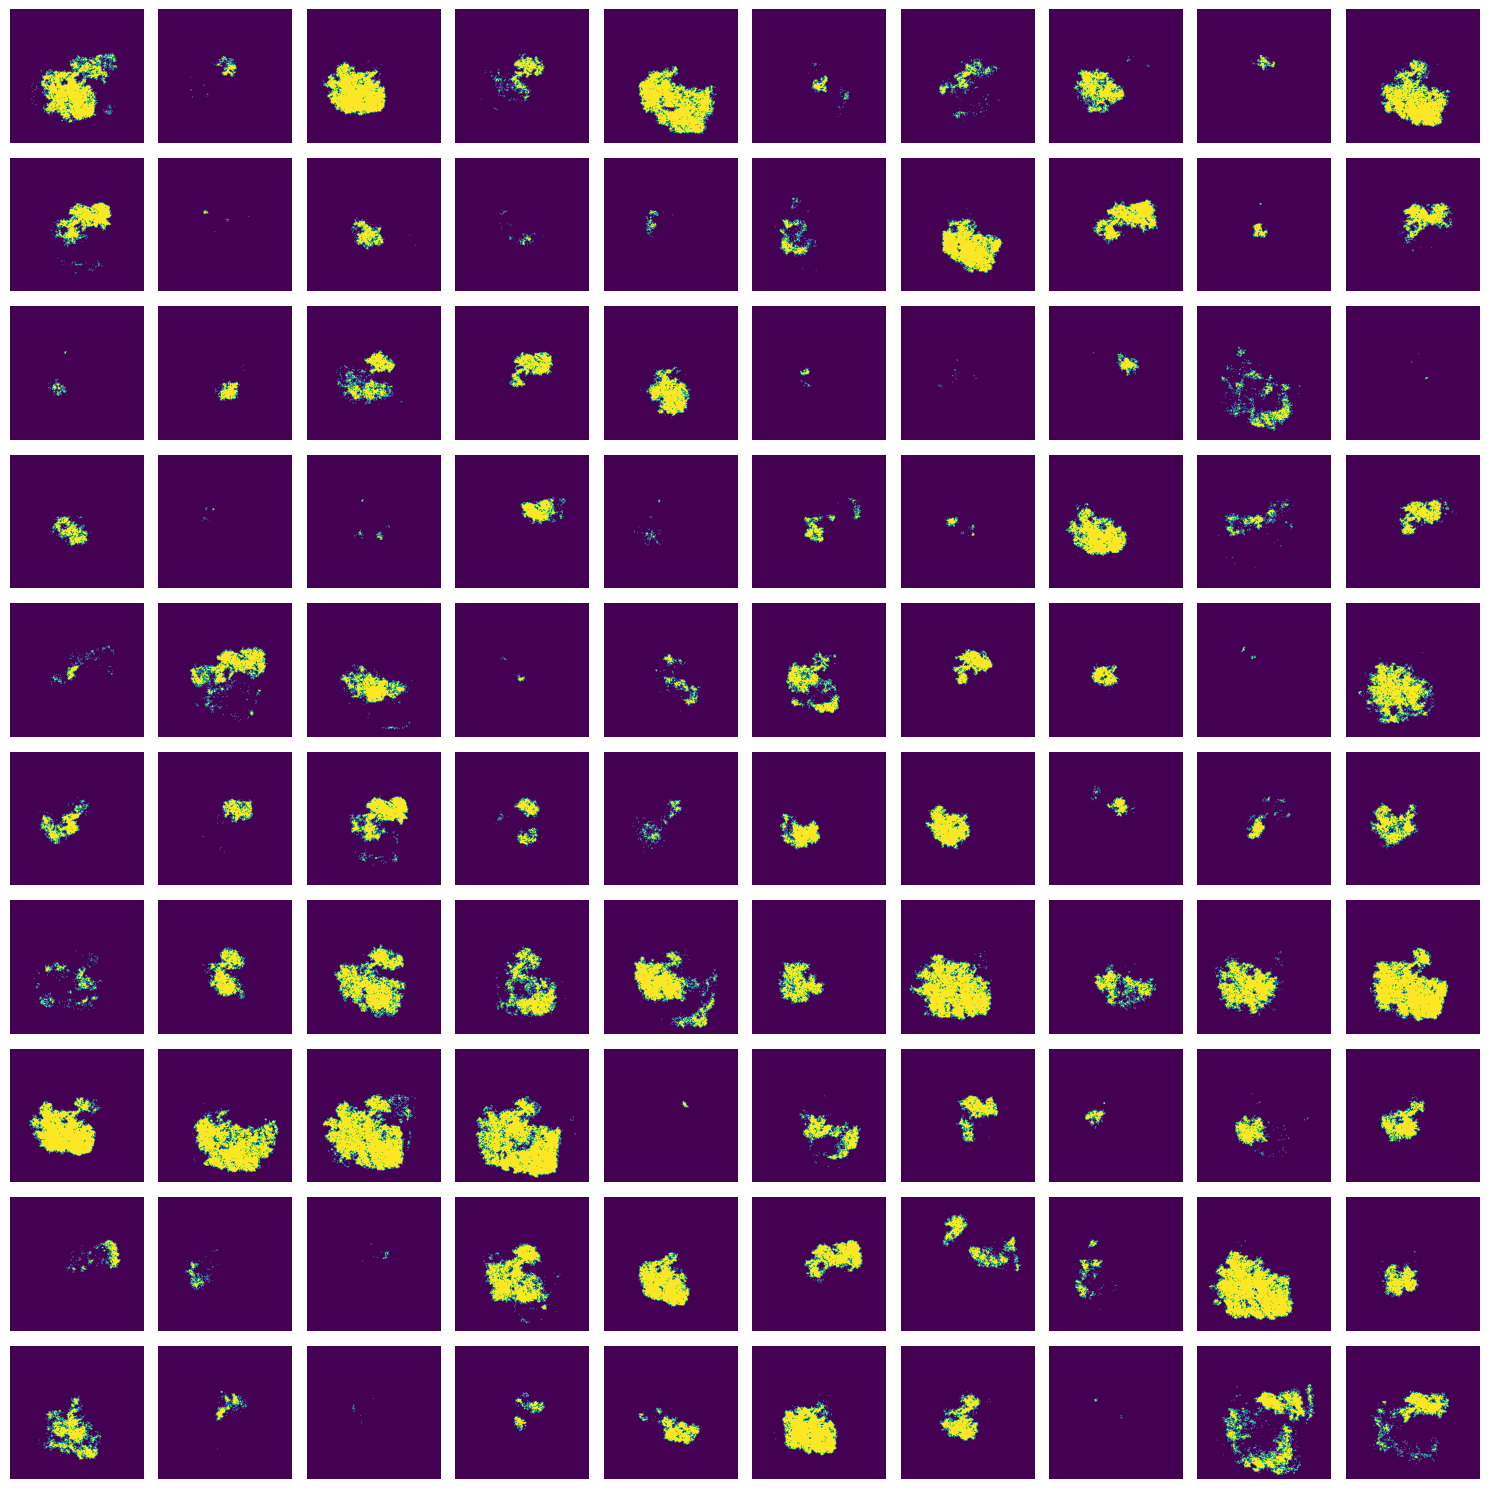

In [72]:
plot_generated_images_from_latent_space(
    model=model,
    num_samples=100,
    latent_dim=16,
    img_dims=(256, 256),
    pixel_threshold=None,
)

* there are a lot of background artefacts when we lower the learning rate for 30 more epochs. Possibly, this starts to really penalise the KL divergence and prioritise the MSE. As you can see, the MSE is still coming down, albeit slowly. The addiitonal 30 epochs made the generated images much worse.

[2] - previous "baseline": `[512 -> 256 -> 128 -> 16]: lr=0.001: nn.ReLU(): batchsize = 32` 

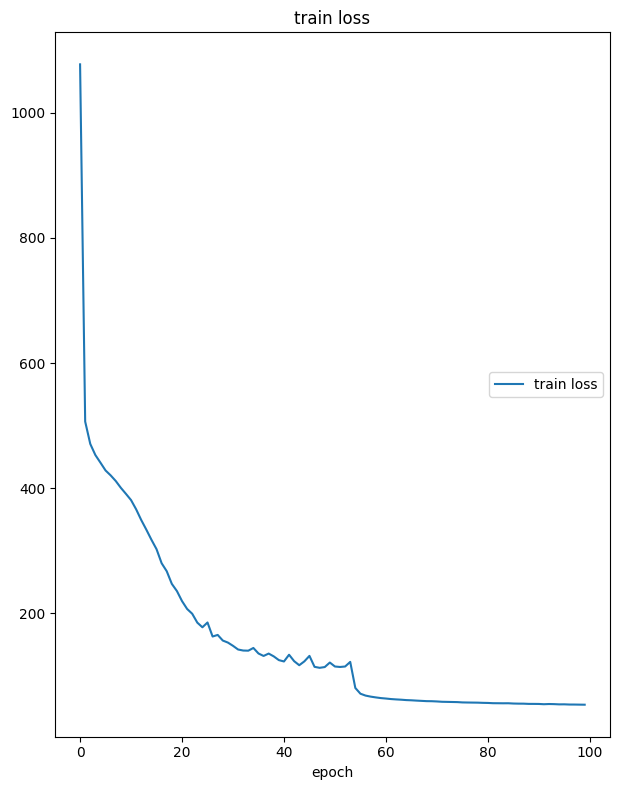

Epoch: 99/100 | Batch: 547/547: 100%|██████████| 54700/54700 [26:59<00:00, 33.78batch/s, loss=49.2]

train loss
	train loss       	 (min:   53.512, max: 1077.731, cur:   53.512)


In [78]:
model = VAE(
    input_image_dims=(1, 256, 256),
    hidden_layers=[512, 256, 128],
    latent_dims=16,
    activation=nn.ReLU,
    device=DEVICE,
).to(DEVICE)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, amsgrad=False)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode="min", factor=0.1, patience=5
)

model, train_losses, val_losses = train_vae(
    n_epochs=100,
    model=model,
    optimizer=optimizer,
    scheduler=scheduler,
    train_loader=train_loader,
    val_loader=None,
    model_save_path="vae_relu_512_256_128_ld16_bs32_001_all_data_100epochs.pt",
    use_liveloss=True,
    device=DEVICE,
)

* training pattern is similar to the "winner" of the grid search but the lr scheduler kicks in much earlier. 
* the MSE is slightly lower too @ **53.512**.



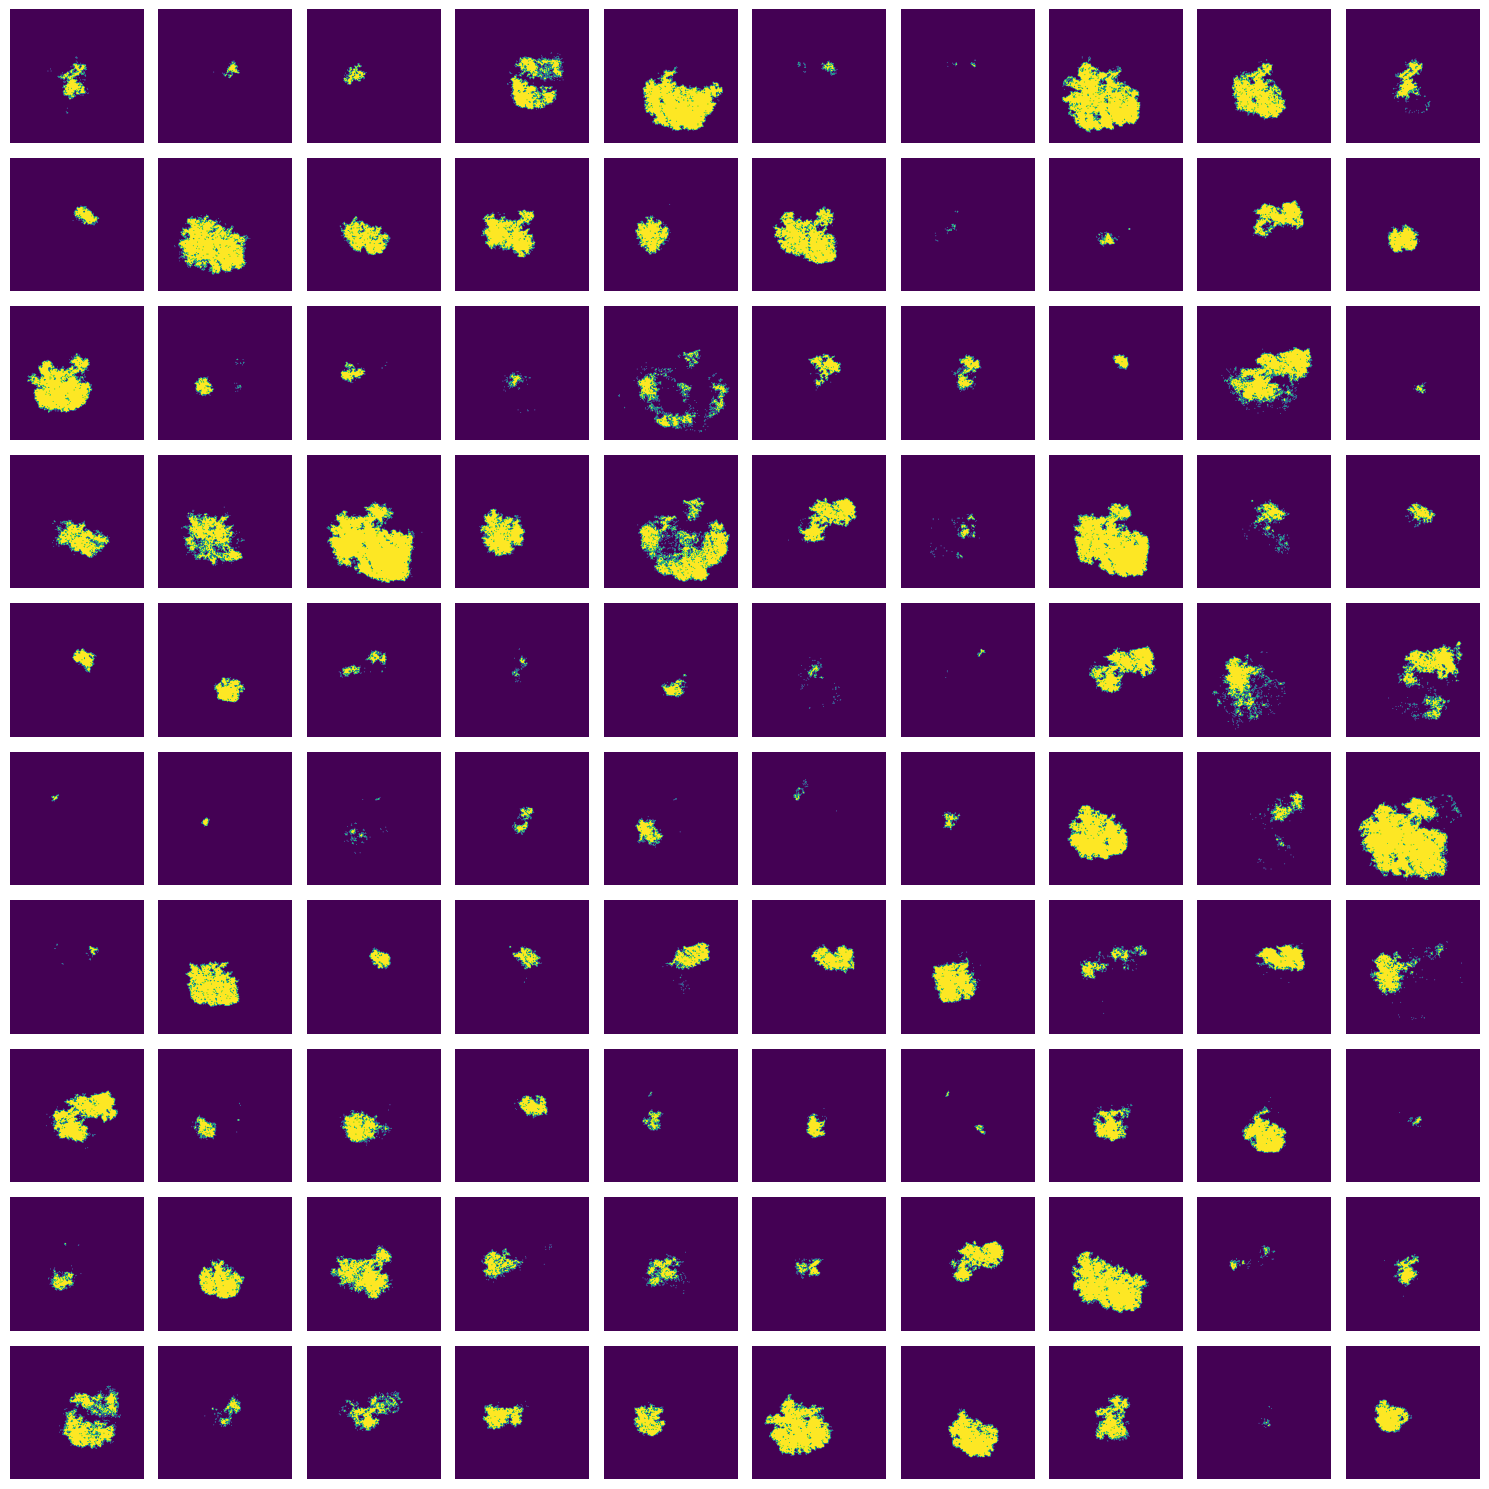

In [79]:
plot_generated_images_from_latent_space(
    model=model,
    num_samples=100,
    latent_dim=16,
    img_dims=(256, 256),
    pixel_threshold=None,
)

* the generated images for the previous "baseline" model look **BETTER** than the grid search winner. They appear much less sparce and the clusters themselves are much more realistic.

#### [training squeeze]: dropping the learning rate by factor of 10 and running it for 20 more epochs using 0.0001 (1e-4)

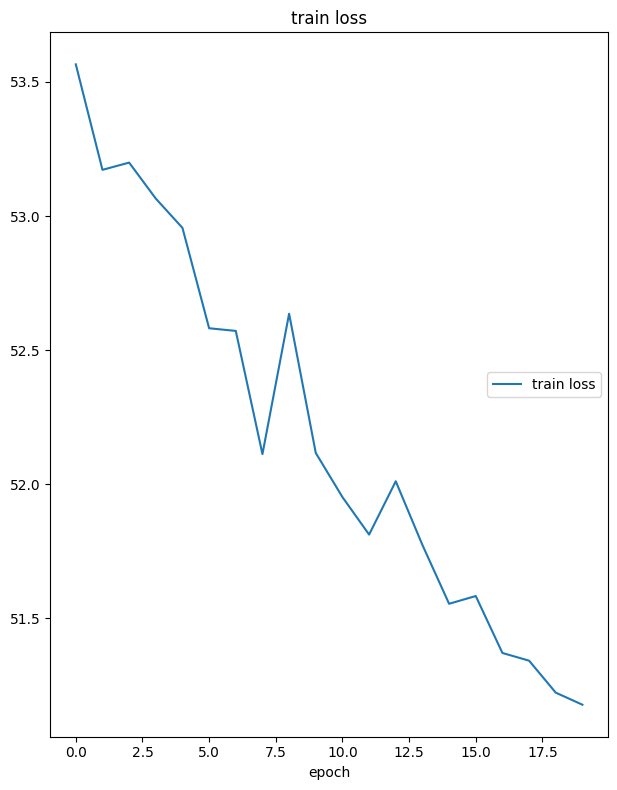

Epoch: 19/20 | Batch: 547/547: 100%|██████████| 10940/10940 [06:06<00:00, 29.82batch/s, loss=51.8]

train loss
	train loss       	 (min:   51.178, max:   53.566, cur:   51.178)


In [84]:
# load in the best model:
path = "vae_relu_512_256_128_ld16_bs32_001_all_data_100epochs.pt"
model.load_state_dict(
    torch.load(path, map_location=torch.device(DEVICE))["model_state_dict"]
)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, amsgrad=True)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode="min", factor=0.1, patience=3
)

model, train_losses, val_losses = train_vae(
    n_epochs=20,
    model=model,
    optimizer=optimizer,
    scheduler=scheduler,
    train_loader=train_loader,
    val_loader=None,
    model_save_path="vae_relu_512_256_128_ld16_bs32_001_all_data_100epochs_2_0001.pt",
    use_liveloss=True,
    device=DEVICE,
)

* similar to the previous **training squeeze**, the MSE slightly drops but only very marginally.

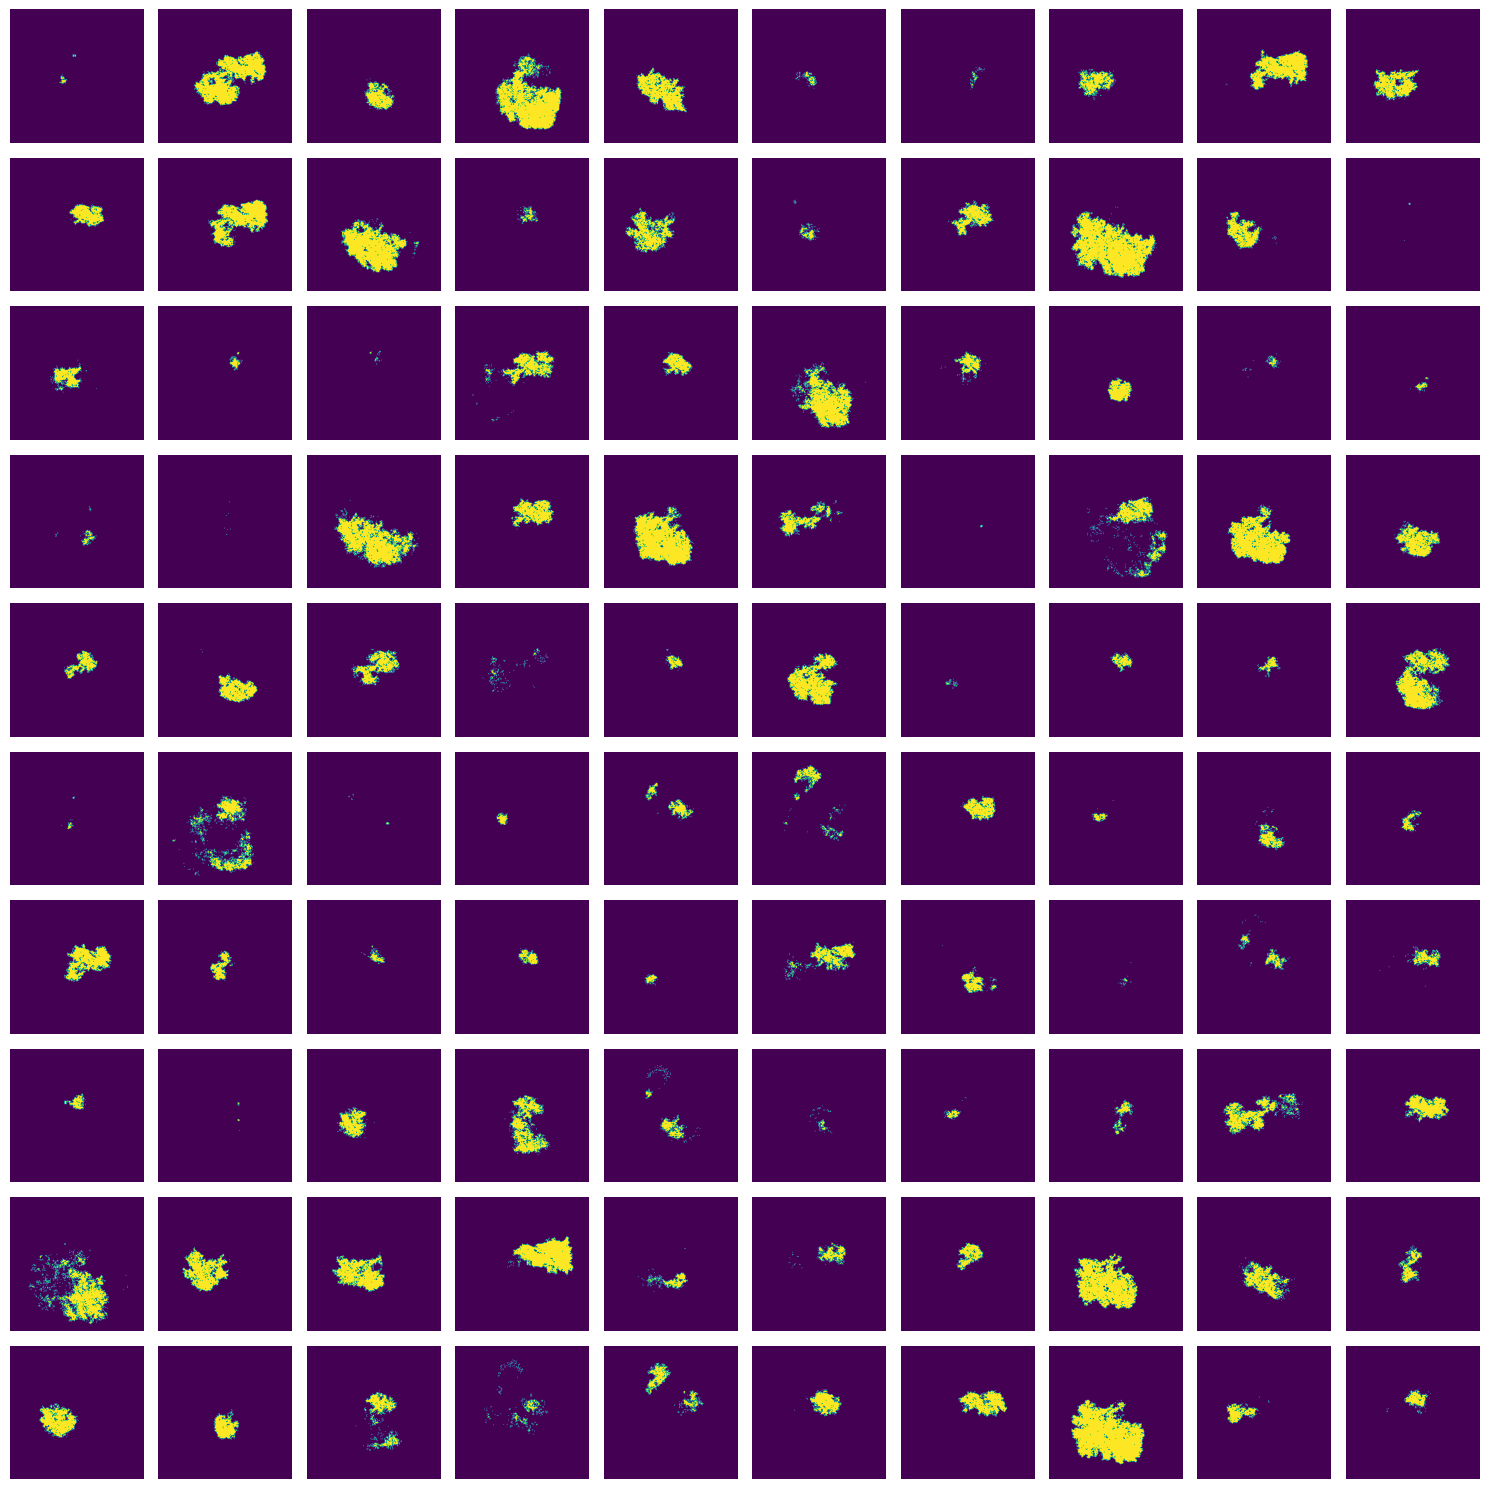

In [85]:
plot_generated_images_from_latent_space(
    model=model,
    num_samples=100,
    latent_dim=16,
    img_dims=(256, 256),
    pixel_threshold=None,
)

* for the previous baseline model, it is harder to determine if the **training squeeze** made the generated image worse. 
* we think that it did. 
* even though the fires, when the model generates a developed one, is very realistic, there are a higher number of wildfires that have a lot of random, unrealistic noise like a line of pixels.


Based on the 2 previous training squeezes, they seem to make the reconstructions worse. We will not continue with the squeezed models.

#### An ode to `ELU`...

* we wanted to try `ELU` one more time.

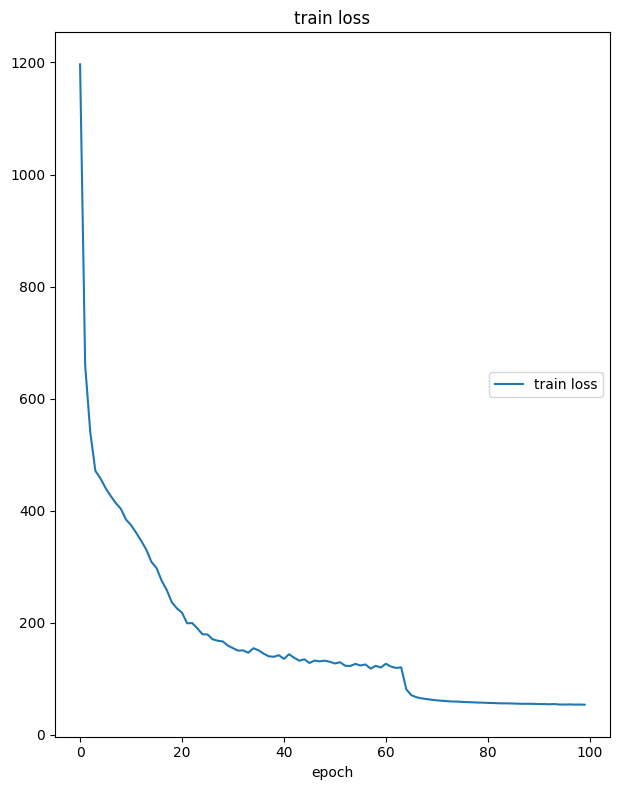

Epoch: 99/100 | Batch: 547/547: 100%|██████████| 54700/54700 [26:51<00:00, 33.94batch/s, loss=53.7]

train loss
	train loss       	 (min:   53.634, max: 1196.631, cur:   53.634)


In [87]:
model = VAE(
    input_image_dims=(1, 256, 256),
    hidden_layers=[512, 256, 128],
    latent_dims=16,
    activation=nn.ELU,
    device=DEVICE,
).to(DEVICE)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, amsgrad=False)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode="min", factor=0.1, patience=5
)

model, train_losses, val_losses = train_vae(
    n_epochs=100,
    model=model,
    optimizer=optimizer,
    scheduler=scheduler,
    train_loader=train_loader,
    val_loader=None,
    model_save_path="vae_elu_512_256_128_ld16_bs32_001_all_data_100epochs.pt",
    use_liveloss=True,
    device=DEVICE,
)

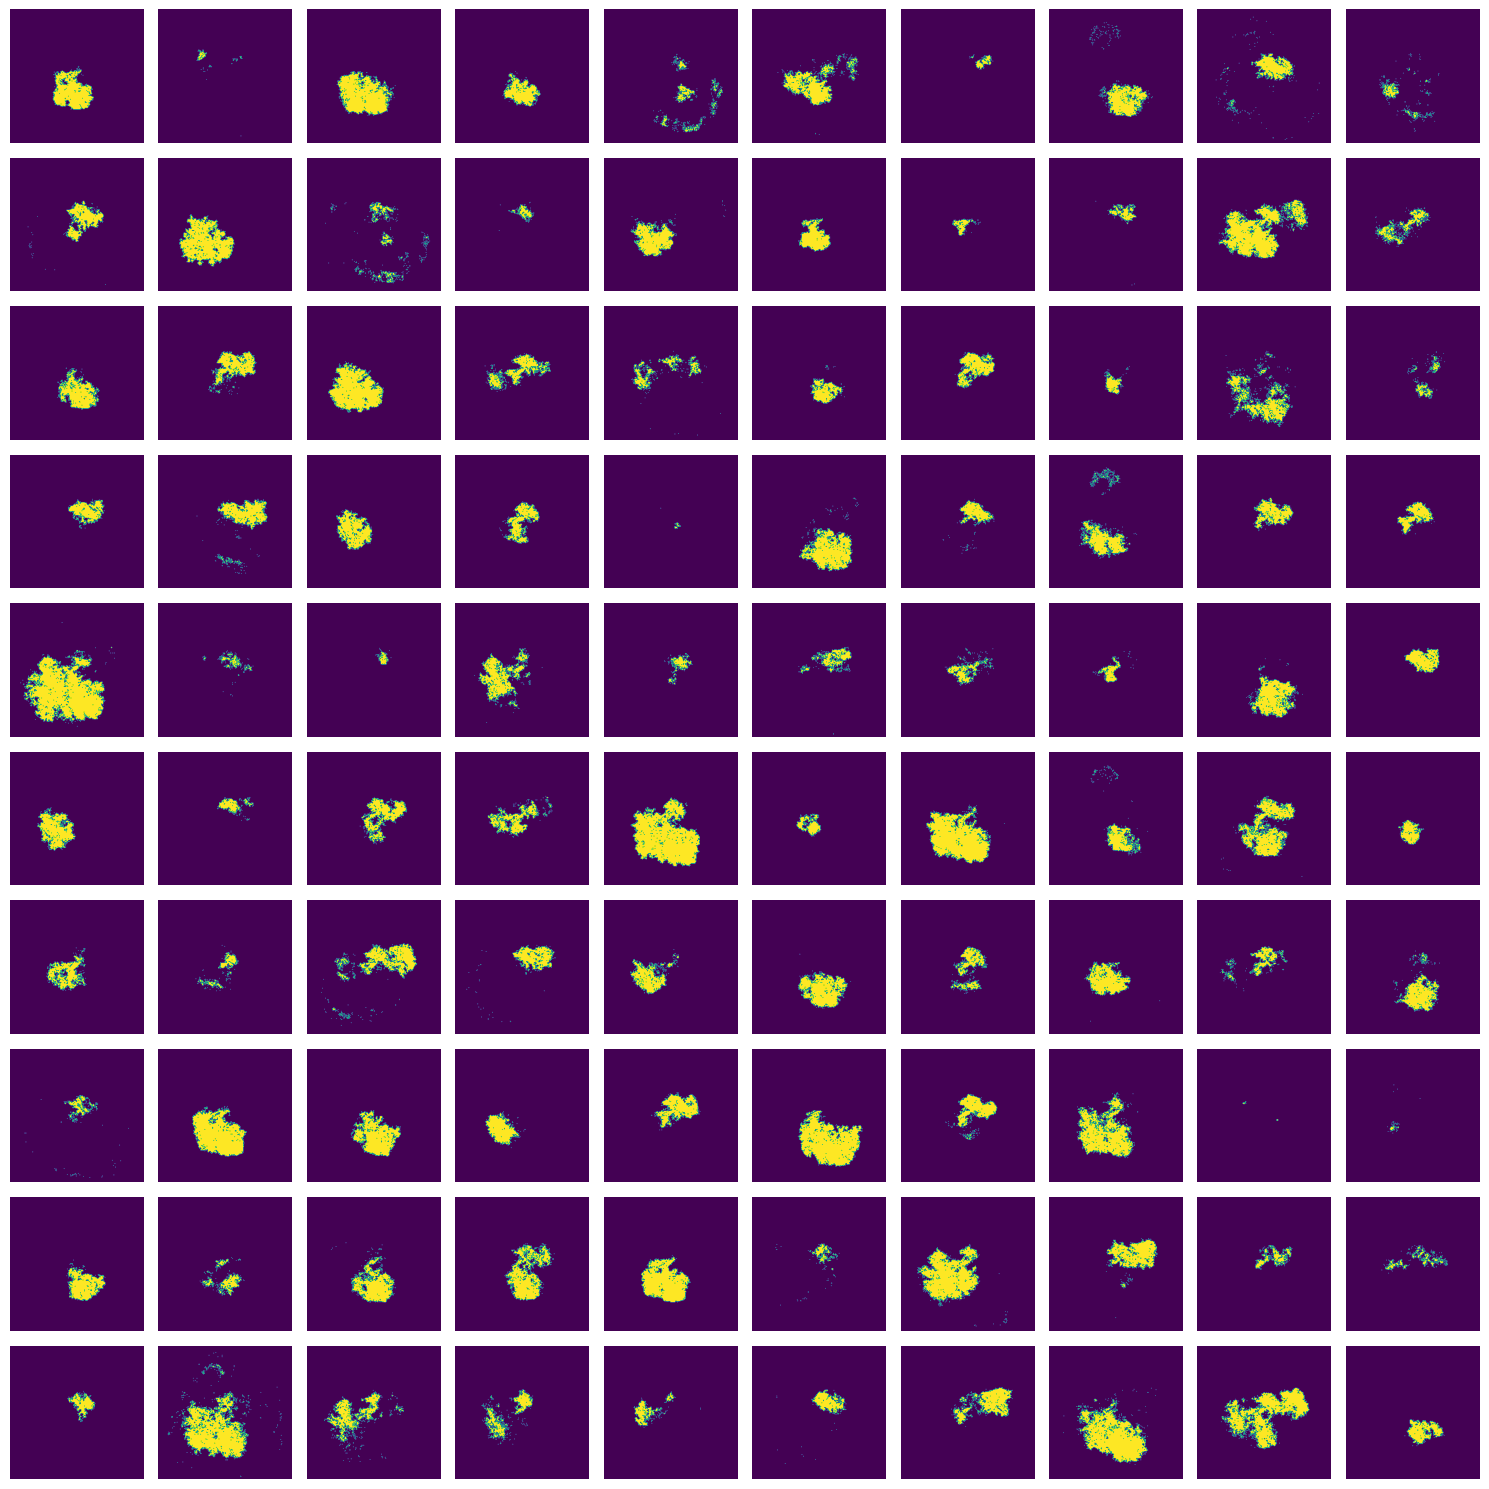

In [88]:
plot_generated_images_from_latent_space(
    model=model,
    num_samples=100,
    latent_dim=16,
    img_dims=(256, 256),
    pixel_threshold=None,
)

* the images are still okay but definitely not better than when using `ReLU`. 
* without clear visual improvements, `ELU`'s ability to destabilise training (see `FCVAE_tuning.ipynb`) leads us to remaining with `RELU` -  ocaam's razor.

#### Loading in the final BEST model (= previous "baseline") after 100 epochs:

In [13]:
model = VAE(
    input_image_dims=(1, 256, 256),
    hidden_layers=[512, 256, 128],
    latent_dims=16,
    activation=nn.ReLU,  # starting w/ RELU
    device=DEVICE,
).to(DEVICE)

In [15]:
# load in the best model:
path = "vae_relu_512_256_128_ld16_bs32_001_all_data_100epochs.pt"
model.load_state_dict(
    torch.load(path, map_location=torch.device(DEVICE))["model_state_dict"]
)

<All keys matched successfully>

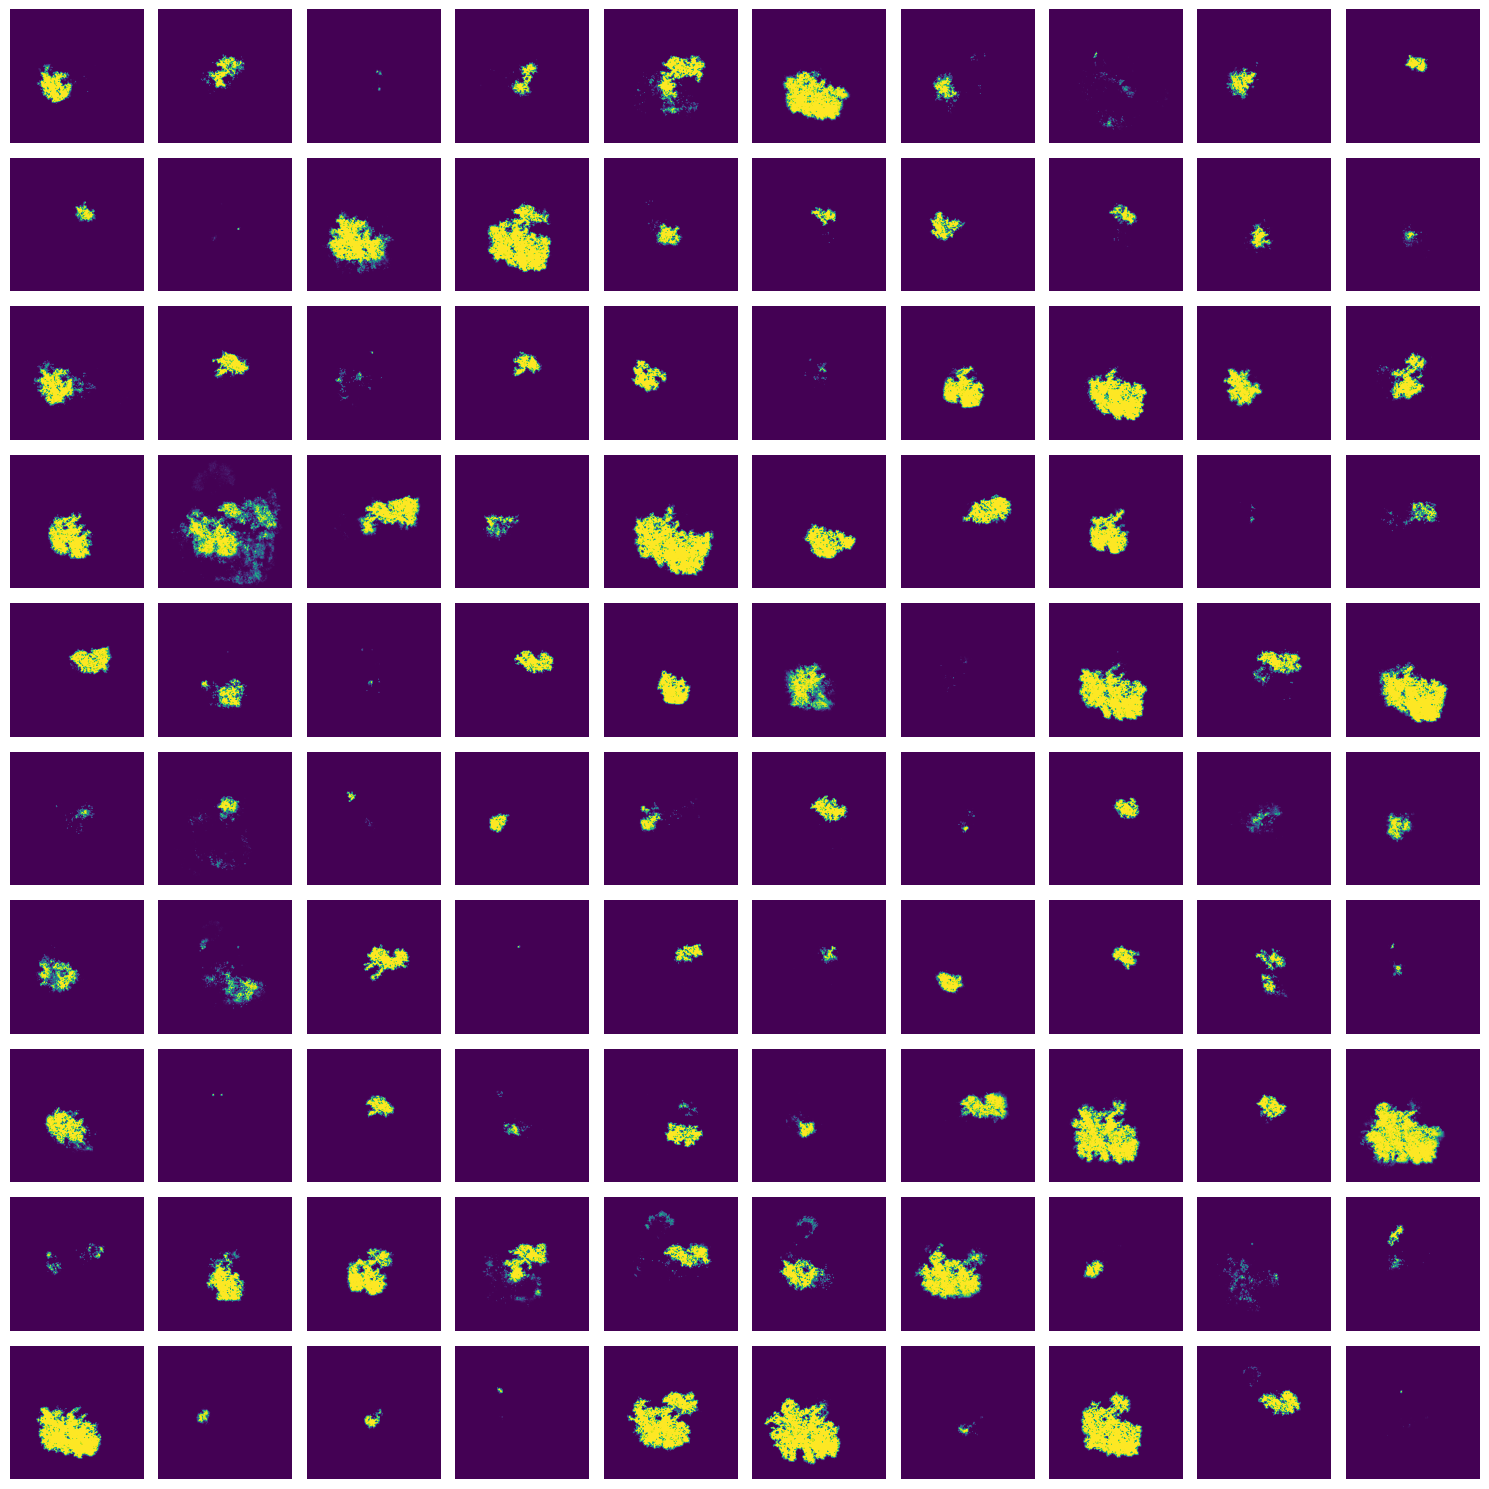

In [27]:
plot_generated_images_from_latent_space(
    model=model,
    num_samples=100,
    latent_dim=16,
    img_dims=(256, 256),
    pixel_threshold=None,
)

### Conclusions:

* decision to use  `[512 -> 256 -> 128 -> 16]: lr=0.001: nn.ReLU(): batchsize = 32` as the final model.
* decision to remain with `RELU` and not `ELU`
* decision to NOT do a **train squeeze**
* the generated images are good. There is definitely some discontinuity in the latent space meaning we sometimes get some incorrect artefacts but for a simple fully-connected VAE it is preoducing good outputs. 